# Predictions with Uncertainties

#### What is a prediction?

The heart of data science is transforming data into predictions: we transform data into features (inputs) and labels (results), use these to train a predictive model from machine learning algorithms, and then feed new data inputs into the trained model to predict new labels. These predictions consist of two components: 

1. The label's *best estimate* and 
2. The *prediction uncertainty*, which characterizes the quality of the prediction. The prediction uncertainty also consists of two components: 
    1. The *bounds* described either by a "$\pm$" or by a high and low, and 
    2. A *confidence interval* (or CI) that gives the probability that the actual result will fall within the bounds.

Because we use predictions as the basis for making decisions, it is vital to understand the quality of the predictions. For example, consider a model that predicts that the stock market will go up by 10 points tomorrow with an uncertainty of $\pm15$ points with a 50% CI. This means that the model is predicting a 50% chance that the stock market will move somewhere between a 5 point loss and a 25 point gain. Neither the size of the bounds nor the confidence interval indicate that this is a high quality prediction; it would be difficult to make an effective decision based on this prediction. On the other hand, if our model predicted with a 95% CI that the stock market would go up 3 points with an uncertainty of $\pm0.1$ points, even though the prediction is much smaller, our confidence in that prediction is significantly higher and we could act with a corresponding confidence on our prediction.

Our goal is to make useful predictions where we understand the prediction uncertainty and confidence interval. I describe in this article methods for determining the prediction uncertainty for regression and classification models. We begin with a regression model that leads to a numerical prediction on a continuous scale.

# A Regression Model

The first step is to build a predicitve model based on data. I consider the case of supervised learning where I break up the data into training an testing sets, train the model on the training data set and use the test dataset to check the accuracy of our model. (See [here](https://github.com/madsenmj/ml-introduction-course) for a more extended introduction to supervised learning.)

## Linear Regression Data

I begin with an example where we want to predict the price of a pen where the input variable is the proximity (in days) to the first day of a new school year. I generate a set of pseudo-random numbers and assign the pen prices accordingly: `10,000` data points are enough to train the model and get good statistics on the test portion of the data set (using an 80%/20% train/test split).

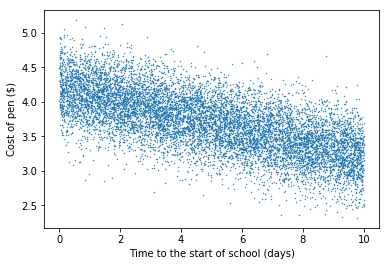

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

npts = 10000
np.random.seed(23)
X = np.random.random(npts)*10
Y = (1-X/10.0) * (1+ np.random.normal(0,0.05,X.shape)) + 3.2*(
    1+np.random.normal(0,0.1,X.shape))
data = pd.DataFrame({'input':X,'output':Y})
plt.scatter(X,Y,s=0.2)
plt.xlabel('Time to the start of school (days)')
plt.ylabel('Cost of pen ($)')
plt.savefig('penmodel.jpg',dpi=300)

I follow the typical pattern for developing a machine learning model by splitting the data into training/testing data sets, training the model, then fitting the test data to the model.

In [2]:
from sklearn.model_selection import train_test_split
# Step 1: Split the data into train/test sets
train, test = train_test_split(data, test_size=0.2, random_state=23)

from sklearn.linear_model import LinearRegression
regr = LinearRegression()

# Step 2: Train the model using the training sets
train_features = train[['input']].values
train_labels = train['output'].values

regr.fit(train_features,train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

I now make predictions of the test data using the `predict` function. The residuals (the actual test point values $Y_i$ minus the predicted values $Y_\textrm{pred}$) give me the uncertainty range for the predictions. The square root of the mean of the squares of the residuals (or root-mean-squared-error, RMSE) 

<center>$\chi=\sqrt{\frac{1}{N}\sum_{i=0}^{N}{(Y_i-Y_\textrm{pred})^2}}$ </center>

estimates the average size of the uncertainty for my test points. This is the 68% CI prediction uncertainty range; doubled it becomes the 95% CI range (because we have many, normally distributed, data points).

In [3]:
from sklearn.metrics import mean_squared_error
test_features = test[['input']].values
test_labels = test['output'].values
predictions = regr.predict(test_features)
residuals = (predictions-test_labels)
chi = np.sqrt(mean_squared_error(predictions, test_labels))
print(2*chi)

0.639505897649


If I plot the residuals and the bounds of the 95% confidence interval range, I should find that 95% of the test points lie within the 95% CI range.

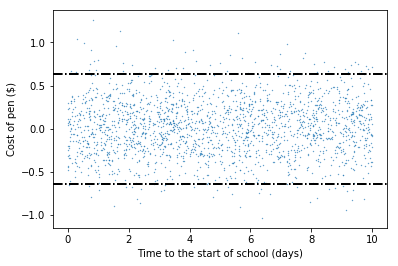

In [4]:
plt.scatter(test_features,residuals,s=0.1)
plt.axhline(y=2*chi, linewidth=2, color = 'k', linestyle='-.')
plt.axhline(y=-2*chi, linewidth=2, color = 'k', linestyle='-.')
plt.xlabel('Time to the start of school (days)')
plt.ylabel('Cost of pen ($)')
plt.savefig('residuals.jpg',dpi=300)

This looks about right and I verify the numerical result: 95% of the predictions should be within 2$\chi$ of the actual values.

In [5]:
np.mean((np.abs(predictions-test_labels) < 2*chi)*1.0)

0.95099999999999996

So, the 95% CI predictions cover what I know about the data and my model. I now predict individual points and give a confidence interval in my prediction. For example, I predict that, 4.2 days from the start of school, the price of pens will be `$(3.78±0.64)`. I visualize the prediction and see that I cover most of the test data with my CI.

Prediction: $(3.78±0.64)


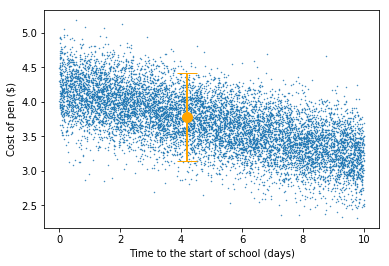

In [6]:
singlePred = regr.predict([[4.2]])
print("Prediction: $({}±0.64)".format(np.round(singlePred,2)[0]))
plt.scatter(X,Y,s=0.2)
plt.gca().errorbar(4.2,singlePred,yerr=0.64, fmt='o',color='orange',capsize=10, elinewidth=2,ms=10)
plt.xlabel('Time to the start of school (days)')
plt.ylabel('Cost of pen ($)')
plt.savefig('penprediction.jpg',dpi=300)

This example highlights the fact that the quality of the data is one of the key factors that determines the quality of the prediction. In this case, the size of the uncertainty bound is tied to the spread in the input data.

# Classification Models

The second type of supervised learning models is classification models. This type of model takes a variety of inputs (either continuous or discrete) and predicts one of a finite, discrete number of classes. Because the output is a discrete class, the uncertainty tools we used for regression models do not apply. Instead, we will use a probabilistic model to determine our confidence in the prediction.

We'll again use "fake" data so that we know what to expect in the end. We imagine a model where we are predicting hair color (`blonde`, `brown` or `black`) based on two inputs: a `curliness` factor that runs from `0` to `1` and a hair length (in centimeters).

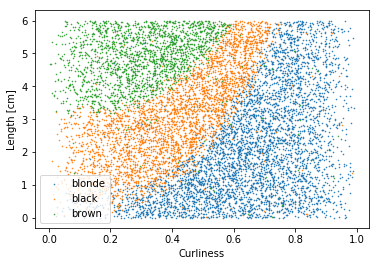

In [7]:
X1 = np.random.beta(2,2,npts)
X2 = np.random.random(npts)*6
ymed =  np.power(X1*3,3) * (1 + np.random.normal(0,0.05,X.shape)) + X2 * (-2 + np.random.normal(0,0.01,X.shape))-0.1*(1+np.random.normal(0,0.1,X.shape))
Y = np.where(ymed + 2*np.random.random(npts) < 0,np.where(ymed + 1*np.random.random(npts) < -6,2,1),0)
Y = np.where(np.random.random(npts)<0.97,Y,np.random.randint(0,3,npts))
data = pd.DataFrame({'input1':X1,'input2':X2,'output':Y})
class_labels = ['blonde','black','brown']
for i in range(3):
    plt.scatter(X1[Y==i],X2[Y==i],s=0.3,label=class_labels[i])
plt.legend()
plt.xlabel("Curliness")
plt.ylabel("Length [cm]")
plt.savefig("haircolor.jpg",dpi=300)

We again follow the standard training pattern: we create our training/testing data split and then train the model using the boosted decision forest model `XGBoost`. It is important that we use a model that gives probabilities for each possible outcome class. We will use these probabilities to generate our uncertainty and a confidence interval for our predictions.

In [8]:
# Train a boosted random forest model
import xgboost as xgb
inputcols = ['input1','input2']
train, test = train_test_split(data, test_size=0.2, random_state=23)
train_features = train[inputcols].values
train_labels = train['output'].values
test_features = test[inputcols].values
test_labels = test['output'].values

dtrain = xgb.DMatrix(train_features, label=train_labels)
dtest= xgb.DMatrix(test_features,label=test_labels)

watchlist  = [(dtest,'eval'), (dtrain,'train')]
param = {'max_depth':5, 'eta':0.08, 'silent':1, 'gamma':1,'objective':'multi:softprob','num_class':3 }
num_round = 100
xgbmodel = xgb.train(param, dtrain, num_round,watchlist,verbose_eval=False)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# make prediction
preds = xgbmodel.predict(dtest)

y_pred = np.argmax(preds,axis=1)


Our next step is to understand the quality of our model using the test (out-of-sample) data. We generate a confusion matrix and normalize it based on the columns of the matrix.

Accuracy Score: 0.9305


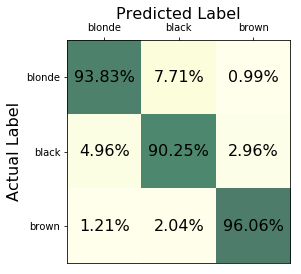

In [9]:
cnf_matrix = confusion_matrix(test_labels, y_pred)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=0)[ np.newaxis,:]

plt.matshow(cnf_matrix,cmap=plt.cm.YlGn,alpha=0.7)
ax = plt.gca()
ax.set_xlabel('Predicted Label', fontsize=16)
ax.set_xticks(range(0,len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_ylabel('Actual Label', fontsize=16, rotation=90)
ax.set_yticks(range(0,len(class_labels)))
ax.set_yticklabels(class_labels)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
for row in range(len(cnf_matrix)):
    for col in range(len(cnf_matrix[row])):
        ax.text(col, row,'{}%'.format(np.round(cnf_matrix[row][col]*100,2)), va='center', ha='center', fontsize=16)    

plt.savefig("confusionmatrix.jpg",dpi=300)
acc_score = accuracy_score(test_labels, y_pred)

print("Accuracy Score: {}".format(acc_score))

The confusion matrix, normalized by column like we have here, gives us a measure of the uncertainty of our predictions. Note that each class has a different uncertainty, based on the shape and details of the predictive model.

The interpretation of the confusion matrix is this:

* If we predict `blonde`, we are `92%` confident that the prediction is accurate.
* If we predict `black`, we are `91%` confident that the prediction is accurate.
* If we predict `brown`, we are `95%` confident that our prediction is accurate.

In terms of typical uncertainty bounds, the 95% confidence interval says that we are `95%` confident that the result lies within those bounds. Classification predictions are slightly different in that we can't give an interval, though we can give a set of inputs that lead to a prediction of a given class with a 95% confidence interval. For a multidimensional input case, this would efficiently be done using a Monte-Carlo simulation. We visualize this in our two-dimensional input case. We plot the `95%` confidence points on the plot, giving us an effective `95%` confidence region, or the regions in which we are `95%` confident that our predictions are accurate.

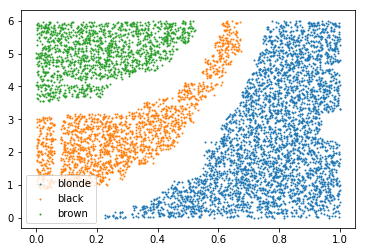

In [10]:
mcpoints = 10000
mcX1 = np.random.random(mcpoints)
mcX2 = np.random.random(mcpoints)*6

mcprob = xgbmodel.predict(xgb.DMatrix(np.c_[mcX1,mcX2]))
threshold = 0.95

for i in range(3):
    mcy_X1 = mcX1[mcprob[:,i]>threshold]
    mcy_X2 = mcX2[mcprob[:,i]>threshold]
    plt.scatter(mcy_X1,mcy_X2,s=1,label=class_labels[i])
plt.legend()
plt.savefig("classificationprediction.jpg",dpi=300)

We can now make decisions based on our confidence in the predictions. If we are looking at a point within our `95%` confidence interval range, we have a good idea what to expect for the outcome. If our decision lies outside of those ranges, we are correpondingly less confident in the outcome.

# Conclusion

Whether we are predicting continuous values in regression models or predicting output classes, it is essential that our predictions come with a corresponding uncertainty and confidence interval. These intervals give the business decision makers a real sense of the quality of the predictions as they turn them into actions.